# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare data for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a>

It also exists an Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

For now, we gonna focus on the simple version and based on the result, we may try the embedded version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [3]:
x, y = reber.get_one_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BPVPXTTTTTTTTTTVPS
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

In [4]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [21]:
min_length = 10
for i in range(10):
    inp, out = reber.get_one_embedded_example(min_length)
#     print(reber.sequenceToWord(inp))
    print(len(inp))

15
16
16
15
16
16
17
15
15
15


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library

In [32]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

maxlen = 0
for i in range(2048):
    x, y = reber.get_one_embedded_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))
    maxlen = max(maxlen, len(x))

for i in range(256):
    x, y = reber.get_one_embedded_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))
    maxlen = max(maxlen, len(x))
    
for i in range(1):
    x, y = reber.get_one_embedded_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)
    maxlen = max(maxlen, len(x))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 36, 7)
(2048, 36, 7)
(256, 36, 7)
(256, 36, 7)
(1, 36, 7)
(1, 36, 7)
(1, 36, 7)


In [33]:
print(y_possible)

[[[0 1 0 0 1 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 1 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

During the writing of this notebook, I tried some loss, metrics and optimizer. The following ones are the one fitting the best

In [34]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "categorical_crossentropy"
metrics_ = "categorical_crossentropy"
optimizer_ = "Nadam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [35]:
model = Sequential()

model.add(LSTM(units=nb_unit, 
               input_shape=inp_shape, 
               return_sequences=True))  # single LSTM
model.add(Dense(7, activation='softmax'))
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("lstm_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [36]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 36, 7)
Outputs: (None, 36, 7)
Actual input: (2048, 36, 7)
Actual output: (2048, 36, 7)


In [37]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 0.87656, saving model to lstm_simple.h5
 - 2s - loss: 0.8766 - categorical_crossentropy: 0.8766 - val_loss: 0.8389 - val_categorical_crossentropy: 0.8389
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 0.87656 to 0.82919, saving model to lstm_simple.h5
 - 1s - loss: 0.8292 - categorical_crossentropy: 0.8292 - val_loss: 0.7940 - val_categorical_crossentropy: 0.7940
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 0.82919 to 0.78130, saving model to lstm_simple.h5
 - 1s - loss: 0.7813 - categorical_crossentropy: 0.7813 - val_loss: 0.7428 - val_categorical_crossentropy: 0.7428
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.78130 to 0.72755, saving model to lstm_simple.h5
 - 1s - loss: 0.7276 - categorical_crossentropy: 0.7276 - val_loss: 0.6885 - val_categorical_crossentropy: 0.6885
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.24865 to 0.24753, saving model to lstm_simple.h5
 - 1s - loss: 0.2475 - categorical_crossentropy: 0.2475 - val_loss: 0.2424 - val_categorical_crossentropy: 0.2424
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.24753 to 0.24659, saving model to lstm_simple.h5
 - 1s - loss: 0.2466 - categorical_crossentropy: 0.2466 - val_loss: 0.2415 - val_categorical_crossentropy: 0.2415
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.24659 to 0.24566, saving model to lstm_simple.h5
 - 1s - loss: 0.2457 - categorical_crossentropy: 0.2457 - val_loss: 0.2406 - val_categorical_crossentropy: 0.2406
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.24566 to 0.24471, saving model to lstm_simple.h5
 - 1s - loss: 0.2447 - categorical_crossentropy: 0.2447 - val_loss: 0.2397 - val_categorical_crossentropy: 0.2397
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.24471 to 0.24

Epoch 73/250
Epoch 00073: categorical_crossentropy improved from 0.22913 to 0.22898, saving model to lstm_simple.h5
 - 1s - loss: 0.2290 - categorical_crossentropy: 0.2290 - val_loss: 0.2236 - val_categorical_crossentropy: 0.2236
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.22898 to 0.22874, saving model to lstm_simple.h5
 - 1s - loss: 0.2287 - categorical_crossentropy: 0.2287 - val_loss: 0.2233 - val_categorical_crossentropy: 0.2233
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.22874 to 0.22856, saving model to lstm_simple.h5
 - 1s - loss: 0.2286 - categorical_crossentropy: 0.2286 - val_loss: 0.2233 - val_categorical_crossentropy: 0.2233
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.22856 to 0.22835, saving model to lstm_simple.h5
 - 1s - loss: 0.2284 - categorical_crossentropy: 0.2284 - val_loss: 0.2229 - val_categorical_crossentropy: 0.2229
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.22835 to 0.22

Epoch 110/250
Epoch 00110: categorical_crossentropy improved from 0.22431 to 0.22416, saving model to lstm_simple.h5
 - 1s - loss: 0.2242 - categorical_crossentropy: 0.2242 - val_loss: 0.2188 - val_categorical_crossentropy: 0.2188
Epoch 111/250
Epoch 00111: categorical_crossentropy improved from 0.22416 to 0.22412, saving model to lstm_simple.h5
 - 1s - loss: 0.2241 - categorical_crossentropy: 0.2241 - val_loss: 0.2185 - val_categorical_crossentropy: 0.2185
Epoch 112/250
Epoch 00112: categorical_crossentropy improved from 0.22412 to 0.22402, saving model to lstm_simple.h5
 - 1s - loss: 0.2240 - categorical_crossentropy: 0.2240 - val_loss: 0.2185 - val_categorical_crossentropy: 0.2185
Epoch 113/250
Epoch 00113: categorical_crossentropy improved from 0.22402 to 0.22391, saving model to lstm_simple.h5
 - 1s - loss: 0.2239 - categorical_crossentropy: 0.2239 - val_loss: 0.2186 - val_categorical_crossentropy: 0.2186
Epoch 114/250
Epoch 00114: categorical_crossentropy improved from 0.22391 to

Epoch 147/250
Epoch 00147: categorical_crossentropy improved from 0.22186 to 0.22179, saving model to lstm_simple.h5
 - 1s - loss: 0.2218 - categorical_crossentropy: 0.2218 - val_loss: 0.2164 - val_categorical_crossentropy: 0.2164
Epoch 148/250
Epoch 00148: categorical_crossentropy improved from 0.22179 to 0.22169, saving model to lstm_simple.h5
 - 1s - loss: 0.2217 - categorical_crossentropy: 0.2217 - val_loss: 0.2164 - val_categorical_crossentropy: 0.2164
Epoch 149/250
Epoch 00149: categorical_crossentropy improved from 0.22169 to 0.22167, saving model to lstm_simple.h5
 - 1s - loss: 0.2217 - categorical_crossentropy: 0.2217 - val_loss: 0.2167 - val_categorical_crossentropy: 0.2167
Epoch 150/250
Epoch 00150: categorical_crossentropy improved from 0.22167 to 0.22165, saving model to lstm_simple.h5
 - 1s - loss: 0.2217 - categorical_crossentropy: 0.2217 - val_loss: 0.2164 - val_categorical_crossentropy: 0.2164
Epoch 151/250
Epoch 00151: categorical_crossentropy improved from 0.22165 to

Epoch 187/250
Epoch 00187: categorical_crossentropy did not improve
 - 1s - loss: 0.2205 - categorical_crossentropy: 0.2205 - val_loss: 0.2150 - val_categorical_crossentropy: 0.2150
Epoch 188/250
Epoch 00188: categorical_crossentropy improved from 0.22036 to 0.22029, saving model to lstm_simple.h5
 - 1s - loss: 0.2203 - categorical_crossentropy: 0.2203 - val_loss: 0.2150 - val_categorical_crossentropy: 0.2150
Epoch 189/250
Epoch 00189: categorical_crossentropy did not improve
 - 1s - loss: 0.2204 - categorical_crossentropy: 0.2204 - val_loss: 0.2149 - val_categorical_crossentropy: 0.2149
Epoch 190/250
Epoch 00190: categorical_crossentropy did not improve
 - 1s - loss: 0.2203 - categorical_crossentropy: 0.2203 - val_loss: 0.2149 - val_categorical_crossentropy: 0.2149
Epoch 191/250
Epoch 00191: categorical_crossentropy did not improve
 - 1s - loss: 0.2203 - categorical_crossentropy: 0.2203 - val_loss: 0.2150 - val_categorical_crossentropy: 0.2150
Epoch 192/250
Epoch 00192: categorical_cr

Epoch 227/250
Epoch 00227: categorical_crossentropy improved from 0.21960 to 0.21960, saving model to lstm_simple.h5
 - 1s - loss: 0.2196 - categorical_crossentropy: 0.2196 - val_loss: 0.2144 - val_categorical_crossentropy: 0.2144
Epoch 228/250
Epoch 00228: categorical_crossentropy improved from 0.21960 to 0.21957, saving model to lstm_simple.h5
 - 1s - loss: 0.2196 - categorical_crossentropy: 0.2196 - val_loss: 0.2144 - val_categorical_crossentropy: 0.2144
Epoch 229/250
Epoch 00229: categorical_crossentropy improved from 0.21957 to 0.21953, saving model to lstm_simple.h5
 - 1s - loss: 0.2195 - categorical_crossentropy: 0.2195 - val_loss: 0.2145 - val_categorical_crossentropy: 0.2145
Epoch 230/250
Epoch 00230: categorical_crossentropy improved from 0.21953 to 0.21952, saving model to lstm_simple.h5
 - 1s - loss: 0.2195 - categorical_crossentropy: 0.2195 - val_loss: 0.2144 - val_categorical_crossentropy: 0.2144
Epoch 231/250
Epoch 00231: categorical_crossentropy improved from 0.21952 to

In [19]:
LSTM_steps = 250

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [38]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model2.add(Dense(7, activation='softmax'))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("srnn_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [39]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 0.91417, saving model to srnn_simple.h5
 - 1s - loss: 0.9142 - categorical_crossentropy: 0.9142 - val_loss: 0.8603 - val_categorical_crossentropy: 0.8603
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 0.91417 to 0.83965, saving model to srnn_simple.h5
 - 0s - loss: 0.8396 - categorical_crossentropy: 0.8396 - val_loss: 0.7900 - val_categorical_crossentropy: 0.7900
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 0.83965 to 0.77719, saving model to srnn_simple.h5
 - 0s - loss: 0.7772 - categorical_crossentropy: 0.7772 - val_loss: 0.7372 - val_categorical_crossentropy: 0.7372
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.77719 to 0.72912, saving model to srnn_simple.h5
 - 0s - loss: 0.7291 - categorical_crossentropy: 0.7291 - val_loss: 0.6942 - val_categorical_crossentropy: 0.6942
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.25304 to 0.25115, saving model to srnn_simple.h5
 - 0s - loss: 0.2511 - categorical_crossentropy: 0.2511 - val_loss: 0.2448 - val_categorical_crossentropy: 0.2448
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.25115 to 0.24957, saving model to srnn_simple.h5
 - 0s - loss: 0.2496 - categorical_crossentropy: 0.2496 - val_loss: 0.2429 - val_categorical_crossentropy: 0.2429
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.24957 to 0.24801, saving model to srnn_simple.h5
 - 0s - loss: 0.2480 - categorical_crossentropy: 0.2480 - val_loss: 0.2413 - val_categorical_crossentropy: 0.2413
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.24801 to 0.24665, saving model to srnn_simple.h5
 - 0s - loss: 0.2466 - categorical_crossentropy: 0.2466 - val_loss: 0.2400 - val_categorical_crossentropy: 0.2400
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.24665 to 0.24

Epoch 73/250
Epoch 00073: categorical_crossentropy improved from 0.22914 to 0.22899, saving model to srnn_simple.h5
 - 0s - loss: 0.2290 - categorical_crossentropy: 0.2290 - val_loss: 0.2226 - val_categorical_crossentropy: 0.2226
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.22899 to 0.22866, saving model to srnn_simple.h5
 - 0s - loss: 0.2287 - categorical_crossentropy: 0.2287 - val_loss: 0.2231 - val_categorical_crossentropy: 0.2231
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.22866 to 0.22862, saving model to srnn_simple.h5
 - 0s - loss: 0.2286 - categorical_crossentropy: 0.2286 - val_loss: 0.2224 - val_categorical_crossentropy: 0.2224
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.22862 to 0.22842, saving model to srnn_simple.h5
 - 0s - loss: 0.2284 - categorical_crossentropy: 0.2284 - val_loss: 0.2223 - val_categorical_crossentropy: 0.2223
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.22842 to 0.22

Epoch 111/250
Epoch 00111: categorical_crossentropy did not improve
 - 0s - loss: 0.2249 - categorical_crossentropy: 0.2249 - val_loss: 0.2189 - val_categorical_crossentropy: 0.2189
Epoch 112/250
Epoch 00112: categorical_crossentropy improved from 0.22460 to 0.22438, saving model to srnn_simple.h5
 - 0s - loss: 0.2244 - categorical_crossentropy: 0.2244 - val_loss: 0.2185 - val_categorical_crossentropy: 0.2185
Epoch 113/250
Epoch 00113: categorical_crossentropy did not improve
 - 0s - loss: 0.2246 - categorical_crossentropy: 0.2246 - val_loss: 0.2186 - val_categorical_crossentropy: 0.2186
Epoch 114/250
Epoch 00114: categorical_crossentropy did not improve
 - 0s - loss: 0.2244 - categorical_crossentropy: 0.2244 - val_loss: 0.2187 - val_categorical_crossentropy: 0.2187
Epoch 115/250
Epoch 00115: categorical_crossentropy improved from 0.22438 to 0.22422, saving model to srnn_simple.h5
 - 0s - loss: 0.2242 - categorical_crossentropy: 0.2242 - val_loss: 0.2184 - val_categorical_crossentropy:

Epoch 150/250
Epoch 00150: categorical_crossentropy improved from 0.22258 to 0.22245, saving model to srnn_simple.h5
 - 0s - loss: 0.2224 - categorical_crossentropy: 0.2224 - val_loss: 0.2168 - val_categorical_crossentropy: 0.2168
Epoch 151/250
Epoch 00151: categorical_crossentropy did not improve
 - 0s - loss: 0.2225 - categorical_crossentropy: 0.2225 - val_loss: 0.2166 - val_categorical_crossentropy: 0.2166
Epoch 152/250
Epoch 00152: categorical_crossentropy improved from 0.22245 to 0.22239, saving model to srnn_simple.h5
 - 0s - loss: 0.2224 - categorical_crossentropy: 0.2224 - val_loss: 0.2174 - val_categorical_crossentropy: 0.2174
Epoch 153/250
Epoch 00153: categorical_crossentropy improved from 0.22239 to 0.22239, saving model to srnn_simple.h5
 - 0s - loss: 0.2224 - categorical_crossentropy: 0.2224 - val_loss: 0.2167 - val_categorical_crossentropy: 0.2167
Epoch 154/250
Epoch 00154: categorical_crossentropy improved from 0.22239 to 0.22234, saving model to srnn_simple.h5
 - 0s - 

Epoch 189/250
Epoch 00189: categorical_crossentropy did not improve
 - 0s - loss: 0.2213 - categorical_crossentropy: 0.2213 - val_loss: 0.2156 - val_categorical_crossentropy: 0.2156
Epoch 190/250
Epoch 00190: categorical_crossentropy improved from 0.22116 to 0.22101, saving model to srnn_simple.h5
 - 0s - loss: 0.2210 - categorical_crossentropy: 0.2210 - val_loss: 0.2155 - val_categorical_crossentropy: 0.2155
Epoch 191/250
Epoch 00191: categorical_crossentropy did not improve
 - 0s - loss: 0.2211 - categorical_crossentropy: 0.2211 - val_loss: 0.2158 - val_categorical_crossentropy: 0.2158
Epoch 192/250
Epoch 00192: categorical_crossentropy did not improve
 - 0s - loss: 0.2210 - categorical_crossentropy: 0.2210 - val_loss: 0.2154 - val_categorical_crossentropy: 0.2154
Epoch 193/250
Epoch 00193: categorical_crossentropy improved from 0.22101 to 0.22092, saving model to srnn_simple.h5
 - 0s - loss: 0.2209 - categorical_crossentropy: 0.2209 - val_loss: 0.2154 - val_categorical_crossentropy:

Epoch 230/250
Epoch 00230: categorical_crossentropy did not improve
 - 0s - loss: 0.2201 - categorical_crossentropy: 0.2201 - val_loss: 0.2147 - val_categorical_crossentropy: 0.2147
Epoch 231/250
Epoch 00231: categorical_crossentropy improved from 0.22004 to 0.21998, saving model to srnn_simple.h5
 - 0s - loss: 0.2200 - categorical_crossentropy: 0.2200 - val_loss: 0.2148 - val_categorical_crossentropy: 0.2148
Epoch 232/250
Epoch 00232: categorical_crossentropy improved from 0.21998 to 0.21996, saving model to srnn_simple.h5
 - 0s - loss: 0.2200 - categorical_crossentropy: 0.2200 - val_loss: 0.2149 - val_categorical_crossentropy: 0.2149
Epoch 233/250
Epoch 00233: categorical_crossentropy did not improve
 - 0s - loss: 0.2200 - categorical_crossentropy: 0.2200 - val_loss: 0.2154 - val_categorical_crossentropy: 0.2154
Epoch 234/250
Epoch 00234: categorical_crossentropy improved from 0.21996 to 0.21991, saving model to srnn_simple.h5
 - 0s - loss: 0.2199 - categorical_crossentropy: 0.2199 -

In [18]:
SRNN_steps = 250

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [40]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True))
model3.add(Dense(7, activation='softmax'))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("gru_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [41]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 0.88138, saving model to gru_simple.h5
 - 2s - loss: 0.8814 - categorical_crossentropy: 0.8814 - val_loss: 0.8391 - val_categorical_crossentropy: 0.8391
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 0.88138 to 0.82684, saving model to gru_simple.h5
 - 1s - loss: 0.8268 - categorical_crossentropy: 0.8268 - val_loss: 0.7851 - val_categorical_crossentropy: 0.7851
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 0.82684 to 0.76929, saving model to gru_simple.h5
 - 1s - loss: 0.7693 - categorical_crossentropy: 0.7693 - val_loss: 0.7266 - val_categorical_crossentropy: 0.7266
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 0.76929 to 0.71084, saving model to gru_simple.h5
 - 1s - loss: 0.7108 - categorical_crossentropy: 0.7108 - val_loss: 0.6697 - val_categorical_crossentropy: 0.6697
Epoch 5/250
Epoch 00005: categorical_crossent

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.23193 to 0.23124, saving model to gru_simple.h5
 - 1s - loss: 0.2312 - categorical_crossentropy: 0.2312 - val_loss: 0.2256 - val_categorical_crossentropy: 0.2256
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.23124 to 0.23053, saving model to gru_simple.h5
 - 1s - loss: 0.2305 - categorical_crossentropy: 0.2305 - val_loss: 0.2249 - val_categorical_crossentropy: 0.2249
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.23053 to 0.22994, saving model to gru_simple.h5
 - 1s - loss: 0.2299 - categorical_crossentropy: 0.2299 - val_loss: 0.2242 - val_categorical_crossentropy: 0.2242
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.22994 to 0.22936, saving model to gru_simple.h5
 - 1s - loss: 0.2294 - categorical_crossentropy: 0.2294 - val_loss: 0.2244 - val_categorical_crossentropy: 0.2244
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.22936 to 0.22895,

Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.22197 to 0.22193, saving model to gru_simple.h5
 - 1s - loss: 0.2219 - categorical_crossentropy: 0.2219 - val_loss: 0.2166 - val_categorical_crossentropy: 0.2166
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.22193 to 0.22173, saving model to gru_simple.h5
 - 1s - loss: 0.2217 - categorical_crossentropy: 0.2217 - val_loss: 0.2163 - val_categorical_crossentropy: 0.2163
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.22173 to 0.22166, saving model to gru_simple.h5
 - 1s - loss: 0.2217 - categorical_crossentropy: 0.2217 - val_loss: 0.2162 - val_categorical_crossentropy: 0.2162
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.22166 to 0.22164, saving model to gru_simple.h5
 - 1s - loss: 0.2216 - categorical_crossentropy: 0.2216 - val_loss: 0.2163 - val_categorical_crossentropy: 0.2163
Epoch 78/250
Epoch 00078: categorical_crossentropy improved from 0.22164 to 0.22148,

Epoch 112/250
Epoch 00112: categorical_crossentropy did not improve
 - 1s - loss: 0.2194 - categorical_crossentropy: 0.2194 - val_loss: 0.2136 - val_categorical_crossentropy: 0.2136
Epoch 113/250
Epoch 00113: categorical_crossentropy did not improve
 - 1s - loss: 0.2193 - categorical_crossentropy: 0.2193 - val_loss: 0.2135 - val_categorical_crossentropy: 0.2135
Epoch 114/250
Epoch 00114: categorical_crossentropy improved from 0.21927 to 0.21923, saving model to gru_simple.h5
 - 1s - loss: 0.2192 - categorical_crossentropy: 0.2192 - val_loss: 0.2134 - val_categorical_crossentropy: 0.2134
Epoch 115/250
Epoch 00115: categorical_crossentropy improved from 0.21923 to 0.21914, saving model to gru_simple.h5
 - 1s - loss: 0.2191 - categorical_crossentropy: 0.2191 - val_loss: 0.2136 - val_categorical_crossentropy: 0.2136
Epoch 116/250
Epoch 00116: categorical_crossentropy improved from 0.21914 to 0.21908, saving model to gru_simple.h5
 - 1s - loss: 0.2191 - categorical_crossentropy: 0.2191 - va

Epoch 153/250
Epoch 00153: categorical_crossentropy improved from 0.21784 to 0.21777, saving model to gru_simple.h5
 - 1s - loss: 0.2178 - categorical_crossentropy: 0.2178 - val_loss: 0.2119 - val_categorical_crossentropy: 0.2119
Epoch 154/250
Epoch 00154: categorical_crossentropy did not improve
 - 1s - loss: 0.2179 - categorical_crossentropy: 0.2179 - val_loss: 0.2120 - val_categorical_crossentropy: 0.2120
Epoch 155/250
Epoch 00155: categorical_crossentropy did not improve
 - 1s - loss: 0.2178 - categorical_crossentropy: 0.2178 - val_loss: 0.2113 - val_categorical_crossentropy: 0.2113
Epoch 156/250
Epoch 00156: categorical_crossentropy improved from 0.21777 to 0.21774, saving model to gru_simple.h5
 - 1s - loss: 0.2177 - categorical_crossentropy: 0.2177 - val_loss: 0.2119 - val_categorical_crossentropy: 0.2119
Epoch 157/250
Epoch 00157: categorical_crossentropy improved from 0.21774 to 0.21771, saving model to gru_simple.h5
 - 1s - loss: 0.2177 - categorical_crossentropy: 0.2177 - va

Epoch 193/250
Epoch 00193: categorical_crossentropy did not improve
 - 1s - loss: 0.2167 - categorical_crossentropy: 0.2167 - val_loss: 0.2106 - val_categorical_crossentropy: 0.2106
Epoch 194/250
Epoch 00194: categorical_crossentropy did not improve
 - 1s - loss: 0.2166 - categorical_crossentropy: 0.2166 - val_loss: 0.2105 - val_categorical_crossentropy: 0.2105
Epoch 195/250
Epoch 00195: categorical_crossentropy did not improve
 - 1s - loss: 0.2166 - categorical_crossentropy: 0.2166 - val_loss: 0.2100 - val_categorical_crossentropy: 0.2100
Epoch 196/250
Epoch 00196: categorical_crossentropy improved from 0.21648 to 0.21643, saving model to gru_simple.h5
 - 1s - loss: 0.2164 - categorical_crossentropy: 0.2164 - val_loss: 0.2103 - val_categorical_crossentropy: 0.2103
Epoch 197/250
Epoch 00197: categorical_crossentropy did not improve
 - 1s - loss: 0.2164 - categorical_crossentropy: 0.2164 - val_loss: 0.2103 - val_categorical_crossentropy: 0.2103
Epoch 198/250
Epoch 00198: categorical_cro

Epoch 236/250
Epoch 00236: categorical_crossentropy did not improve
 - 1s - loss: 0.2156 - categorical_crossentropy: 0.2156 - val_loss: 0.2104 - val_categorical_crossentropy: 0.2104
Epoch 237/250
Epoch 00237: categorical_crossentropy improved from 0.21562 to 0.21552, saving model to gru_simple.h5
 - 1s - loss: 0.2155 - categorical_crossentropy: 0.2155 - val_loss: 0.2095 - val_categorical_crossentropy: 0.2095
Epoch 238/250
Epoch 00238: categorical_crossentropy did not improve
 - 1s - loss: 0.2157 - categorical_crossentropy: 0.2157 - val_loss: 0.2095 - val_categorical_crossentropy: 0.2095
Epoch 239/250
Epoch 00239: categorical_crossentropy did not improve
 - 1s - loss: 0.2156 - categorical_crossentropy: 0.2156 - val_loss: 0.2093 - val_categorical_crossentropy: 0.2093
Epoch 240/250
Epoch 00240: categorical_crossentropy did not improve
 - 1s - loss: 0.2159 - categorical_crossentropy: 0.2159 - val_loss: 0.2101 - val_categorical_crossentropy: 0.2101
Epoch 241/250
Epoch 00241: categorical_cro

In [17]:
GRU_steps = 250

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [21]:
print("LSTM :       {:.2f}s".format(t1))
print("Simple RNN : {:.2f}s".format(t2))
print("GRU :        {:.2f}s".format(t3))

NameError: name 't1' is not defined

We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM. Ze can also check the error of prediction. For this I used a Mean Absolute Error as loss fonction and Mean Squared Error as metrics . I used this loss fonction to have the norm 1 between prediction and real output. With the Means Squared Error, the training would take longer as the loss would be smaller as all outputs are below 1. For the metric, I used it to ease the visualisation.

In [68]:
print("epoch", [LSTM_steps, SRNN_steps, GRU_steps])
print("time", [164.06, 181.82, 330.12])

epoch [207, 250, 250]
time [164.06, 181.82, 330.12]


NameError: name 't1' is not defined

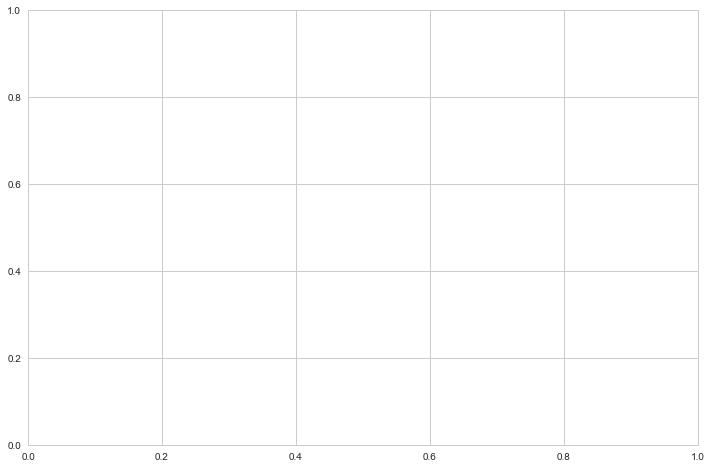

In [20]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("pastel")
sns.barplot(x=[t1, t2, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot_softmax.png")
plt.show()

dict_keys(['val_loss', 'val_categorical_crossentropy', 'loss', 'categorical_crossentropy'])


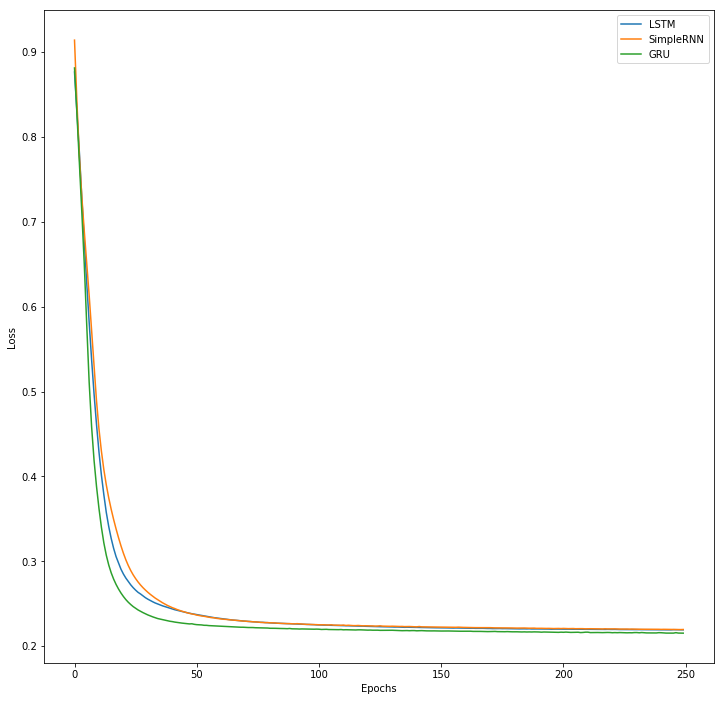

In [42]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.savefig("loss_softmax.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [80]:
print("Input :")
print(X_val)
print("\n\nLSTM predicts :")
y_pred = model.predict(X_val)
print(np.sum(y_pred, axis=2).reshape(-1,1))
print("\n\nGRU predicts :")
y_pred = model3.predict(X_val)
print(np.sum(y_pred, axis=2).reshape(-1,1))
print("\n\nSRNN predicts :")
y_pred = model2.predict(X_val)
print(y_pred)
print(np.sum(y_pred, axis=2).reshape(-1,1))

Input :
[[[1 0 0 0 0 0 0]
  [0 0 0 0 1 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


LSTM predicts :
[[ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]
 [ nan]]


GRU predicts :
[[ 0.974]
 [ 0.807]
 [ 0.719]
 [ 1.184]
 [ 0.944]
 [ 0.999]
 [ 1.426]
 [ 0.957]
 [ 0.999]
 [ 1.212]
 [ 1.52 ]
 [ 0.954]
 [ 0.42 ]
 [ 0.83 ]
 [ 0.903]
 [ 0.944]
 [ 0.976]
 [ 1.005]
 [ 1.022]
 [ 1.029]]


SRNN predicts :
[[[ 0.     0.539  0.001  0.001  0.456  0.001  0.001]
  [ 0.     0.662  0.039  0.051  0.002  0.246  0.   ]
  [ 0.     0.63   0.007  0.005  0.001  0.356  0.   ]
  [ 0.     0.002  0.     0.     0.764  0.232  0.002]
  [

We can simply the output by removing small output and compare it to the possible output (we will only keep prediction from GRU)

In [39]:
y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [40]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.54   0.     0.     0.407  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.     0.66   0.314  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.     0.957  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.628  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.555  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.996  0.319  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.167  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.486  0.     0.     0.     0.51   0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.992  0.499  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.301  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.396  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.689  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.997  0.592  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.    0.    0.37  0.55  0.    0.    0.  ] 	 [0 0 1 1 0 0 0]
[ 0.     0.327  0.     0.     0.     0.59

Yeah !! Output is balanced between both offset but with different "probabilities". We can also check how well they are to generate sentences

## Use it as generator

As explained previously, we trained our model as a many-to-many RNN. Now we want a generator so we are going to use a one-to-many model but reusing knowledge from the training. 

Before that, we will need an evaluation function which take the output, pick the next input based on the probability to have this output, create the next input and run it until the graph is over. After that, we will check is the created word is really a Reber word. This will be done with following functions 

In [2]:
def Pick_From_Output(x):
    y = np.zeros_like(x)
#     x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 100):
    good_pred = 0
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        count_E = 0
        while count_E < 2 and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
            if nextLetter == "E":
                count_E += 1
#         print(word)
        if reber.in_embedded_grammar(word):
            good_pred += 1
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc

In [3]:
nb_samples = 20

Now let's create both model as one-to-many and evaluate them 20 times on 100 words generated.

In [6]:
Model = load_model("lstm_simple.h5")  # lstm_simple /  srnn_simple / gru_simple

newModel = Sequential()
newModel.add(LSTM(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [7]:
result_LSTM = []
for _ in range(nb_samples):
    result_LSTM.append(evaluate(newModel, 100, 50))

Good prediction : 47.00%
Good prediction : 53.00%
Good prediction : 55.00%
Good prediction : 52.00%
Good prediction : 44.00%
Good prediction : 48.00%
Good prediction : 45.00%
Good prediction : 45.00%
Good prediction : 42.00%
Good prediction : 60.00%
Good prediction : 46.00%
Good prediction : 53.00%
Good prediction : 55.00%
Good prediction : 50.00%
Good prediction : 55.00%
Good prediction : 49.00%
Good prediction : 37.00%
Good prediction : 54.00%
Good prediction : 51.00%
Good prediction : 53.00%


In [8]:
Model = load_model("srnn_simple.h5")

newModel = Sequential()
newModel.add(SimpleRNN(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [9]:
result_SRNN = []
for _ in range(nb_samples):
    result_SRNN.append(evaluate(newModel, 100, 50))

Good prediction : 48.00%
Good prediction : 60.00%
Good prediction : 53.00%
Good prediction : 53.00%
Good prediction : 38.00%
Good prediction : 51.00%
Good prediction : 44.00%
Good prediction : 44.00%
Good prediction : 53.00%
Good prediction : 54.00%
Good prediction : 44.00%
Good prediction : 43.00%
Good prediction : 49.00%
Good prediction : 49.00%
Good prediction : 50.00%
Good prediction : 58.00%
Good prediction : 48.00%
Good prediction : 43.00%
Good prediction : 48.00%
Good prediction : 42.00%


In [10]:
Model = load_model("gru_simple.h5")

newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.add(Dense(7, activation='softmax'))
newModel.set_weights(Model.get_weights())

In [11]:
result_GRU = []
for _ in range(nb_samples):
    result_GRU.append(evaluate(newModel, 100, 50))

Good prediction : 54.00%
Good prediction : 45.00%
Good prediction : 60.00%
Good prediction : 55.00%
Good prediction : 57.00%
Good prediction : 53.00%
Good prediction : 63.00%
Good prediction : 63.00%
Good prediction : 60.00%
Good prediction : 62.00%
Good prediction : 62.00%
Good prediction : 56.00%
Good prediction : 48.00%
Good prediction : 56.00%
Good prediction : 49.00%
Good prediction : 58.00%
Good prediction : 62.00%
Good prediction : 55.00%
Good prediction : 57.00%
Good prediction : 62.00%


In [12]:
import pandas as pd

d = {'LSTM': result_LSTM, 'Simple RNN': result_SRNN, 'GRU' : result_GRU}
df = pd.DataFrame(data=d)

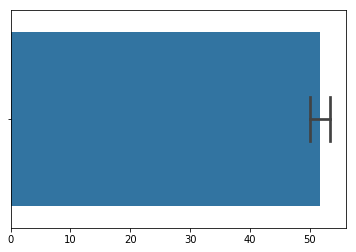

In [13]:
sns.barplot(x=["LSTM", "Simple RNN", "GRU"], data=df, capsize=.2)

So we can see that bost LSTM and GRU outperform the standard RNN. In average LSTM is slightly better than GRU but takes also more time to train.

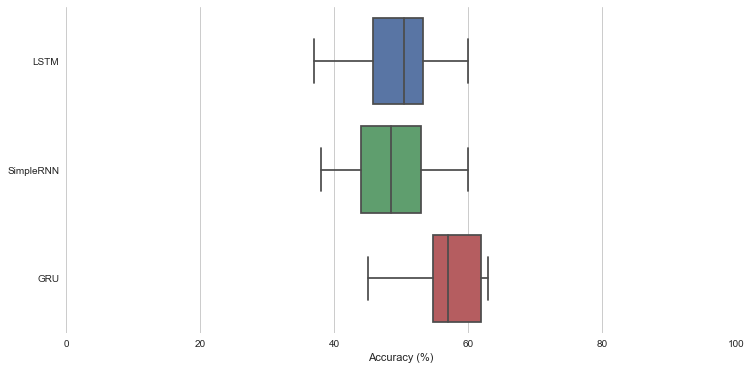

In [14]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.boxplot(x=[result_LSTM, result_SRNN, result_GRU], y=["LSTM", "SimpleRNN", "GRU"])
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy (%)")
sns.despine(left=True, bottom=True)
plt.savefig("boxplot.png")
plt.show()

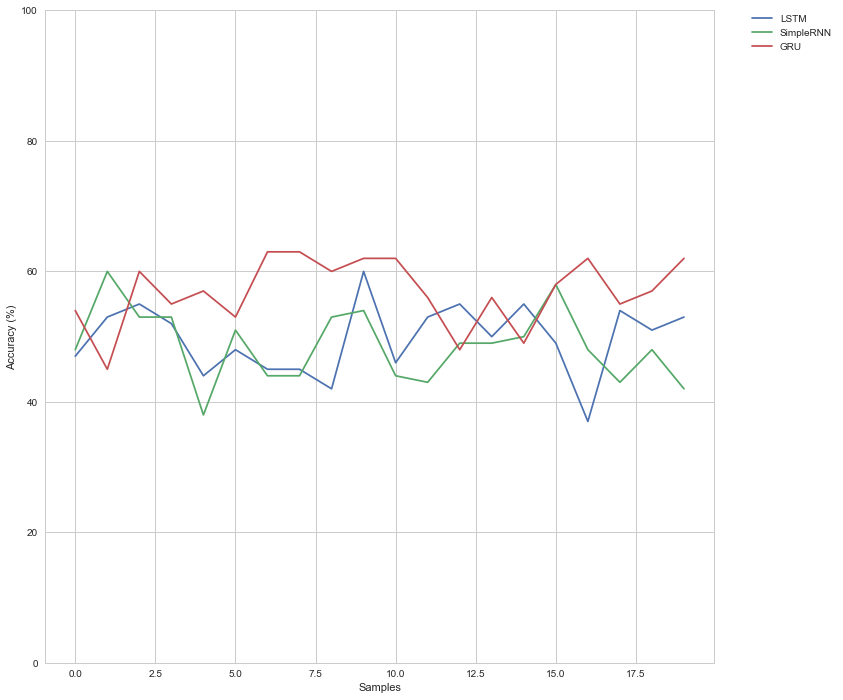

In [16]:
x = list(range(nb_samples))
y = [result_LSTM, result_SRNN, result_GRU]
labels = ["LSTM", "SimpleRNN", "GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)


plt.xlabel("Samples")
plt.ylabel("Accuracy (%)")
plt.ylim((0,100))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("test_result.png")
plt.show()

## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs